# Defining the surface

In archNEMESIS the surface can be described according to three different models selected based on the value of the lower boundary condition (*LOWBC*) flag. These three models are:

- (0) The surface is assumed not to reflect any light (i.e. albedo equal to zero), but to emit it through thermal emission based on the surface temperature and the spectral emissivity. 
   
- (1) The surface is defined as a Lambertian surface, which reflects light isotropically, and emits light based on the spectral emissivity and the surface temperature. The albedo of the surface is defined based on the *GALB* parameter. If *GALB* $\geq$ 0, then the albedo at all wavelengths is assumed to be the same and equal to *GALB*. If *GALB* $\lt$ 0, then the surface albedo is calculated from the spectral emissivity as $a(\lambda) = 1-\epsilon(\lambda)$.

- (2) The reflection of light on the surface is calculated using the Hapke semi-empirical model described in [Hapke (2012)](https://doi.org/10.1017/CBO9781139025683). The emission is considered isotropic as in the other cases based on the surface emissivity and the temperature.

- (3) The reflection of light on the surface is calculated using the generalisation of the Lambertian reflectance model described by [Oren & Nayar (1998)](https://doi.org/10.1145/192161.192213). The emission is considered isotropic as in the other cases based on the surface emissivity and the temperature.

In this notebook, we provide some examples on how the built-in functions on the Surface class can be used to define the surface parameters and better understand the different reflection models.

In [67]:
import archnemesis as ans
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap
from copy import copy

## Thermal emitting surface

In the case that *LOWBC* = 0, the surface is assumed to only emit through thermal emission. The emission is calculated based on the spectral surface emissivity specified in the *.sur* file and the surface temperature specified in the *.set* file, following 

\begin{equation}
    R_S(\lambda) = \epsilon (\lambda) \cdot B_\lambda(T_S),
\end{equation}

where $\epsilon (\lambda)$ is the spectral surface emissivity and $B_\lambda(T)$ is the blackbody function at temperature $T_S$.

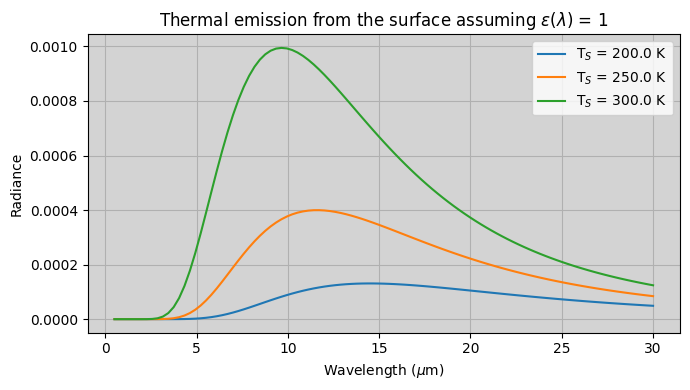

In [68]:
Surface = ans.Surface_0(LOWBC=0)


#Writing a .sur file with some values
Surface.NEM = 101
Surface.VEM = np.linspace(0.5,30.,Surface.NEM)  #0.5-20 um
Surface.EMISSIVITY = np.ones(Surface.NEM) * 1.0
runname = 'emissivity'
Surface.write_sur(runname)


#Reading the .sur file
Surface.read_sur(runname)


#Calculating the thermal emission from the surface
ISPACE = 1   #(0) Wavenumber (1) Wavelength

fig,ax1 = plt.subplots(1,1,figsize=(7,4))
tsurf = np.linspace(200.,300.,3)
for i in range(len(tsurf)):
    Surface.TSURF = tsurf[i]  
    radground = Surface.calc_radground(ISPACE)  #Calculate at the wavelengths tabulated in the .sur file

    ax1.plot(Surface.VEM,radground,label='T$_S$ = '+str(tsurf[i])+' K')
    
    
ax1.set_title('Thermal emission from the surface assuming $\epsilon(\lambda)$ = 1')
ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('Radiance')
ax1.grid()
ax1.legend()
ax1.set_facecolor('lightgray')
plt.tight_layout()

## Lambertian surface reflectance

In the case that *LOWBC* = 1, the surface is assumed to reflect and emit light isotropically. The bi-directional reflectance distribution function (BRDF) for a Lambertian surface is therefore given by:

\begin{equation}
\mathrm{BRDF}_L (i,e,\psi) = \dfrac{A}{\pi},
\end{equation}

where $A$ is the albedo of the surface and $i$ is the solar incident angle, $e$ is the emission angle and $\psi$ is the azimuth angle.. Given this $\mathrm{BRDF}$ distribution, we can calculate the reflected radiance at any direction using

\begin{equation}
r_L (i,e,\psi) = \mathrm{BRDF}_L \cdot E_0 \cdot \cos(i),
\end{equation}

where $E_0$ is the incident solar irradiance. We can see, that the reflected radiance from a Lambertian surface will be independent of the observer position, and will only depend on the incident angle.

The Lambert albedo of the surface is specified using the *GALB* parameter of the class. There are two possible cases:

- If *GALB* $\geq$ 0.0, then the Lambert albedo is given by this value and it is assumed to be spectrally constant.
- If *GALB* $\lt$ 0.0, then the Lambert albedo is calculated as $A_L(\lambda) = 1-\epsilon(\lambda)$, where $\epsilon$ is the surface emissivity specified on the *.sur* file

In [69]:
#Reading geometry for different cases to perform some example calculations

#Case 1
M = ans.Measurement_0()
M.read_hdf5('case1')
lat_subobs1 = M.LATITUDE ; lon_subobs1 = M.LONGITUDE
lats1 = M.FLAT[:,0] ; lons1 = M.FLON[:,0] ; emiss_ang1 = M.EMISS_ANG[:,0] ; sol_ang1 = M.SOL_ANG[:,0] ; azi_ang1 = M.AZI_ANG[:,0]

#Case 2
M.read_hdf5('case2')
lat_subobs2 = M.LATITUDE ; lon_subobs2 = M.LONGITUDE
lats2 = M.FLAT[:,0] ; lons2 = M.FLON[:,0] ; emiss_ang2 = M.EMISS_ANG[:,0] ; sol_ang2 = M.SOL_ANG[:,0] ; azi_ang2 = M.AZI_ANG[:,0]

#Case 3
M.read_hdf5('case3')
lat_subobs3 = M.LATITUDE ; lon_subobs3 = M.LONGITUDE
lats3 = M.FLAT[:,0] ; lons3 = M.FLON[:,0] ; emiss_ang3 = M.EMISS_ANG[:,0] ; sol_ang3 = M.SOL_ANG[:,0] ; azi_ang3 = M.AZI_ANG[:,0]

In [70]:
#Initialising Surface class
Surface = ans.Surface_0()

#Setting up the Lambertian surface
Surface.LOWBC = 1                                     #Lambertian surface reflectance
Surface.GALB = 1.                                     #Lambertian albedo
Surface.NEM = 2                                       #Number of wavelengths
Surface.VEM = np.array([0.2,0.3])                     #Dummy wavelengths
Surface.EMISSIVITY = np.ones(Surface.NEM) * 1.0       #Emissivity

#Calculating the reflectance
wave = np.array([0.25])   #Dummy wavelength
R1 = Surface.calc_reflectance(wave,sol_ang1,emiss_ang1,azi_ang1)
R2 = Surface.calc_reflectance(wave,sol_ang2,emiss_ang2,azi_ang2)
R3 = Surface.calc_reflectance(wave,sol_ang3,emiss_ang3,azi_ang3)


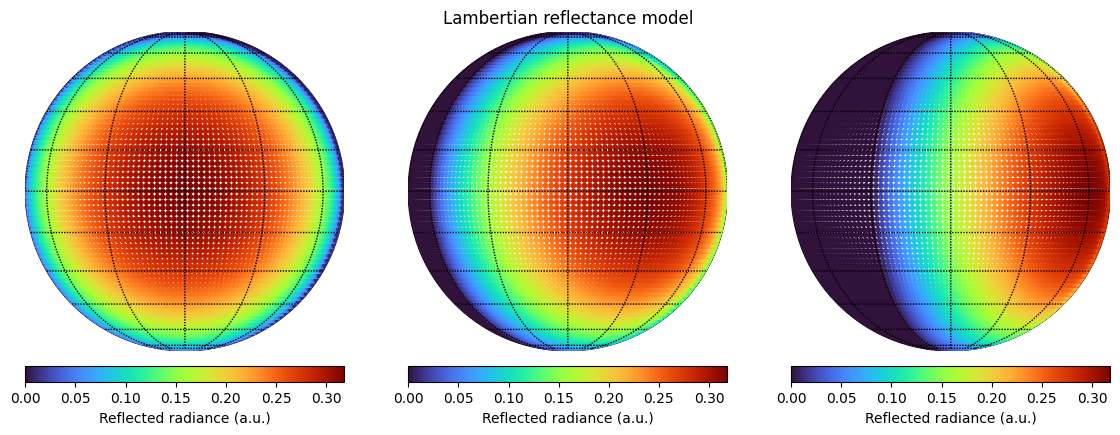

In [71]:
fig = plt.figure(figsize=(14,7))

psize = 10.
cmap = 'turbo'

vmin = 0.
vmax = np.max(np.array([R1.max(),R2.max(),R3.max()]))

#Case 1
ax1 = plt.subplot2grid((1,3),(0,0),rowspan=1,colspan=1)
map = Basemap(projection='ortho', resolution=None,
    lat_0=lat_subobs1, lon_0=lon_subobs1)

latplot = map.drawparallels(np.linspace(-90, 90, 13))
lonplot = map.drawmeridians(np.linspace(-180, 180, 13))
im = map.scatter(lons1,lats1,latlon=True,c=R1,s=psize,vmin=vmin,vmax=vmax,cmap=cmap)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="5%", pad=0.15)
cbar2 = plt.colorbar(im,cax=cax,orientation='horizontal')
cbar2.set_label('Reflected radiance (a.u.)')

#Case 2
ax2 = plt.subplot2grid((1,3),(0,1),rowspan=1,colspan=1)
map = Basemap(projection='ortho', resolution=None,
    lat_0=lat_subobs1, lon_0=lon_subobs1)

latplot = map.drawparallels(np.linspace(-90, 90, 13))
lonplot = map.drawmeridians(np.linspace(-180, 180, 13))
im = map.scatter(lons2,lats2,latlon=True,c=R2,s=psize,vmin=vmin,vmax=vmax,cmap=cmap)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax2)
cax = divider.append_axes("bottom", size="5%", pad=0.15)
cbar2 = plt.colorbar(im,cax=cax,orientation='horizontal')
cbar2.set_label('Reflected radiance (a.u.)')

ax2.set_title('Lambertian reflectance model')


#Case 3
ax3 = plt.subplot2grid((1,3),(0,2),rowspan=1,colspan=1)
map = Basemap(projection='ortho', resolution=None,
    lat_0=lat_subobs1, lon_0=lon_subobs1)

latplot = map.drawparallels(np.linspace(-90, 90, 13))
lonplot = map.drawmeridians(np.linspace(-180, 180, 13))
im = map.scatter(lons2,lats2,latlon=True,c=R3,s=psize,vmin=vmin,vmax=vmax,cmap=cmap)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax3)
cax = divider.append_axes("bottom", size="5%", pad=0.15)
cbar3 = plt.colorbar(im,cax=cax,orientation='horizontal')
cbar3.set_label('Reflected radiance (a.u.)')


## Hapke surface reflectance

In the case that *LOWBC = 2*, the surface is assumed to reflect light according to the Hapke model and to emit light isotropically through thermal emission as in the previous cases. The parameters defining the Hapke surface are assumed to be defined in the same spectral grid as the surface emissivity. The input parameters defining the surface in this model are:

- $\omega$ (*SGLALB*): Single scattering albedo of the surface.
- $K$ (*K*): Porosity coefficient.
- $B_{S_0}$ (*BS0*)*: Amplitude of the opposition effect.
- $h_S$ (*hs*): Width of the opposition surge.
- $B_{c_0}$ (*BC0*): Amplitude of the backscatter effect.
- $h_c$ (*hc*): Width of the backscatter function.
- $\theta$ (*ROUGHNESS*): Roughness mean slope angle (degrees).
- *G1*, *G2* and *F* define the phase function of the surface, which is modelled using a double Henyey-Greenstein function, where *G1* and *G2* are the asymmetry factor of each of the H-G functions and *F* is the relative contribution of the two (see the Scattering example for a formal definition of the double H-G function).

The BRDF is then calculated using

\begin{equation}
\begin{split}
\mathrm{BRDF}_H (i,e,\psi) &= K \cdot \dfrac{\omega}{4\pi} \cdot \dfrac{\mu_{0e}}{\mu_{0e} + \mu_e} \cdot \\ 
&\quad\left( p(g) \cdot (1+B_{S_0}B_S(g)) + (H(\dfrac{\mu_{0e}}{K})H(\dfrac{\mu_e}{K})-1) \right) \cdot \left( 1+B_{C_0}B_C(g) \right) \cdot S(i,e,g).
\end{split}
\end{equation}

The derivation of the reflectance distribution function and all required quantities is described in detail in [Hapke (2012)](https://www.cambridge.org/core/books/theory-of-reflectance-and-emittance-spectroscopy/C266E1164D5E14DA18141F03D0E0EAB0).

In [81]:
Surface = ans.Surface_0()

#Wavelength grid
Surface.NEM = 2                                  #Number of wavelengths
Surface.VEM = np.array([0.2,0.3])                #Dummy wavelengths

#Hapke parameters
Surface.LOWBC = 2                                #Hapke surface
Surface.SGLALB = np.zeros(Surface.NEM) + 0.5
Surface.K = np.zeros(Surface.NEM) + 1.0
Surface.BS0 = np.zeros(Surface.NEM) + 4.0
Surface.hs = np.zeros(Surface.NEM) + 0.05
Surface.BC0 = np.zeros(Surface.NEM) + 0.0
Surface.hc = np.zeros(Surface.NEM) + 0.01
Surface.ROUGHNESS = np.zeros(Surface.NEM) + 45.
Surface.G1 = np.zeros(Surface.NEM) + 0.66   #Forward scattering
Surface.G2 = np.zeros(Surface.NEM) - 0.2    #Backward scattering
Surface.F = np.zeros(Surface.NEM) + 0.13

#Calculating the reflectance
wave = np.array([0.25])   #Dummy wavelength
R1 = Surface.calc_reflectance(wave,sol_ang1,emiss_ang1,azi_ang1)
R2 = Surface.calc_reflectance(wave,sol_ang2,emiss_ang2,azi_ang2)
R3 = Surface.calc_reflectance(wave,sol_ang3,emiss_ang3,azi_ang3)

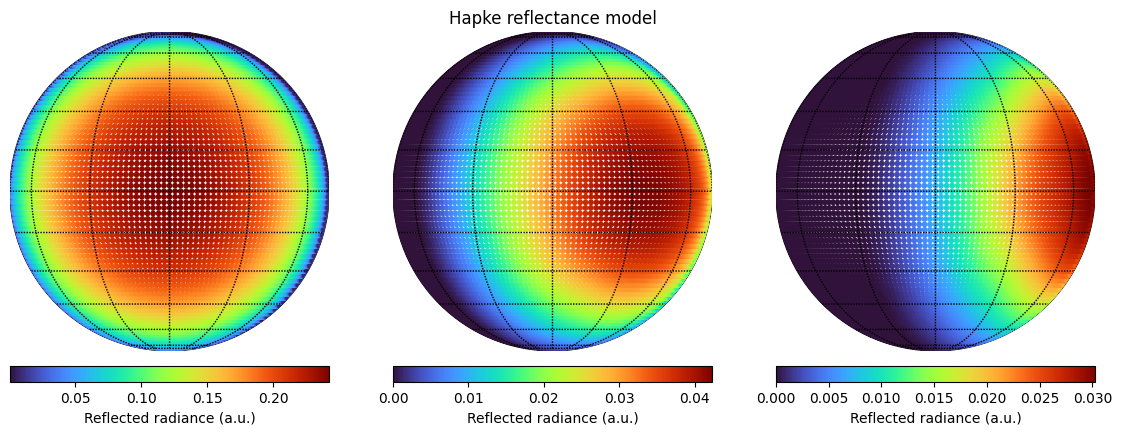

In [82]:
fig = plt.figure(figsize=(14,7))

psize = 10.

vmin = 0.
vmax = np.max(np.array([R1.max(),R2.max(),R3.max()]))
cmap = 'turbo'

#Case 1
ax1 = plt.subplot2grid((1,3),(0,0),rowspan=1,colspan=1)
map = Basemap(projection='ortho', resolution=None,
    lat_0=lat_subobs1, lon_0=lon_subobs1)

latplot = map.drawparallels(np.linspace(-90, 90, 13))
lonplot = map.drawmeridians(np.linspace(-180, 180, 13))
im = map.scatter(lons1,lats1,latlon=True,c=R1,s=psize,cmap=cmap)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="5%", pad=0.15)
cbar2 = plt.colorbar(im,cax=cax,orientation='horizontal')
cbar2.set_label('Reflected radiance (a.u.)')

#Case 2
ax2 = plt.subplot2grid((1,3),(0,1),rowspan=1,colspan=1)
map = Basemap(projection='ortho', resolution=None,
    lat_0=lat_subobs1, lon_0=lon_subobs1)

latplot = map.drawparallels(np.linspace(-90, 90, 13))
lonplot = map.drawmeridians(np.linspace(-180, 180, 13))
im = map.scatter(lons2,lats2,latlon=True,c=R2,s=psize,cmap=cmap)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax2)
cax = divider.append_axes("bottom", size="5%", pad=0.15)
cbar2 = plt.colorbar(im,cax=cax,orientation='horizontal')
cbar2.set_label('Reflected radiance (a.u.)')

ax2.set_title('Hapke reflectance model')


#Case 3
ax3 = plt.subplot2grid((1,3),(0,2),rowspan=1,colspan=1)
map = Basemap(projection='ortho', resolution=None,
    lat_0=lat_subobs1, lon_0=lon_subobs1)

latplot = map.drawparallels(np.linspace(-90, 90, 13))
lonplot = map.drawmeridians(np.linspace(-180, 180, 13))
im = map.scatter(lons2,lats2,latlon=True,c=R3,s=psize,cmap=cmap)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax3)
cax = divider.append_axes("bottom", size="5%", pad=0.15)
cbar3 = plt.colorbar(im,cax=cax,orientation='horizontal')
cbar3.set_label('Reflected radiance (a.u.)')

## Oren-Nayar surface reflectance

In the case that *LOWBC = 3*, the surface is assumed to reflect light according to the model of [Oren & Nayar (1994)](https://doi.org/10.1145/192161.192213). This model is a generalisation of the Lambertian reflecntance distribution function to account for the roughness of the surface. The input parameters defining the surface in this model are:

- $A$ (*ALBEDO*): Albedo of the surface.
- $\theta$ (*ROUGHNESS*): Roughness of the surface (degrees).

These parameters can vary spectrally and are assumed to be defined in the same spectral grid as the emissivity of the surface. In the case that the roughness of the surface is zero, this model converges to a Lambertian surface.

In [83]:
Surface = ans.Surface_0()

#Wavelength grid
Surface.NEM = 2                                  #Number of wavelengths
Surface.VEM = np.array([0.2,0.3])                #Dummy wavelengths

#Hapke parameters
Surface.LOWBC = 3                                #Hapke surface
Surface.ALBEDO = np.zeros(Surface.NEM) + 0.5
Surface.ROUGHNESS = np.zeros(Surface.NEM) + 0.  

#Calculating the reflectance
wave = np.array([0.25])   #Dummy wavelength
R1 = Surface.calc_reflectance(wave,sol_ang1,emiss_ang1,azi_ang1)
R2 = Surface.calc_reflectance(wave,sol_ang2,emiss_ang2,azi_ang2)
R3 = Surface.calc_reflectance(wave,sol_ang3,emiss_ang3,azi_ang3)

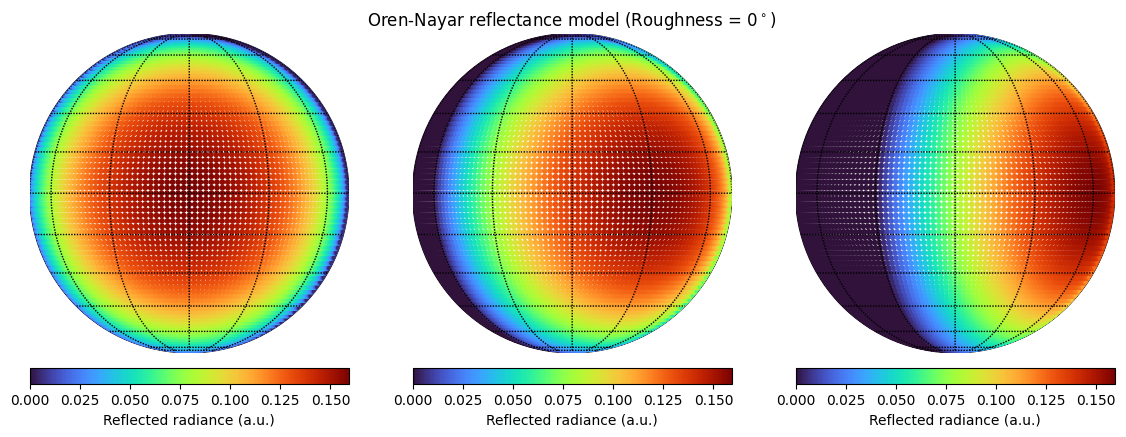

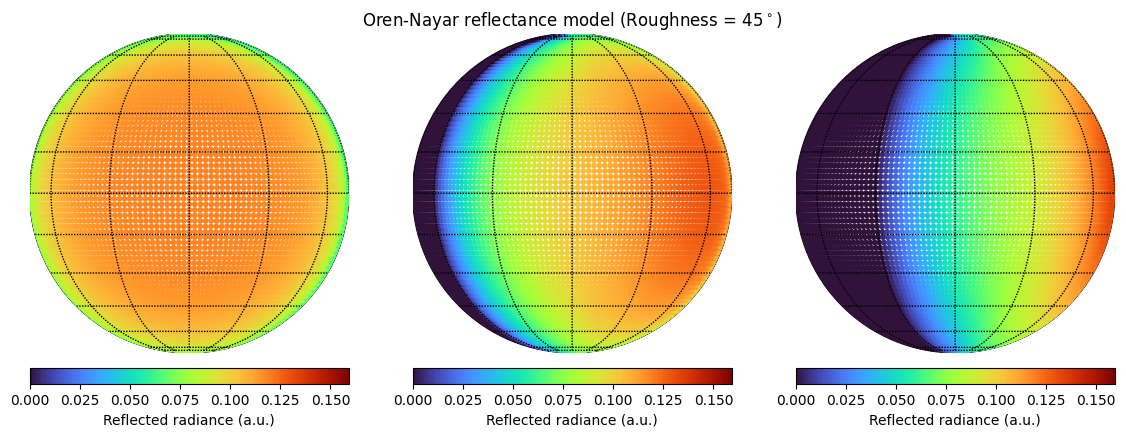

In [84]:
#ROUGHNES = 0
################################################################################

#Calculating the reflectance
Surface.ROUGHNESS[:] = 0.
wave = np.array([0.25])   #Dummy wavelength
R1 = Surface.calc_reflectance(wave,sol_ang1,emiss_ang1,azi_ang1)
R2 = Surface.calc_reflectance(wave,sol_ang2,emiss_ang2,azi_ang2)
R3 = Surface.calc_reflectance(wave,sol_ang3,emiss_ang3,azi_ang3)

fig = plt.figure(figsize=(14,7))

psize = 10.
cmap = 'turbo'

vmin = 0.
vmax = np.max(np.array([R1.max(),R2.max(),R3.max()]))

#Case 1
ax1 = plt.subplot2grid((1,3),(0,0),rowspan=1,colspan=1)
map = Basemap(projection='ortho', resolution=None,
    lat_0=lat_subobs1, lon_0=lon_subobs1)

latplot = map.drawparallels(np.linspace(-90, 90, 13))
lonplot = map.drawmeridians(np.linspace(-180, 180, 13))
im = map.scatter(lons1,lats1,latlon=True,c=R1,s=psize,cmap=cmap,vmin=vmin,vmax=vmax)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="5%", pad=0.15)
cbar2 = plt.colorbar(im,cax=cax,orientation='horizontal')
cbar2.set_label('Reflected radiance (a.u.)')

#Case 2
ax2 = plt.subplot2grid((1,3),(0,1),rowspan=1,colspan=1)
map = Basemap(projection='ortho', resolution=None,
    lat_0=lat_subobs1, lon_0=lon_subobs1)

latplot = map.drawparallels(np.linspace(-90, 90, 13))
lonplot = map.drawmeridians(np.linspace(-180, 180, 13))
im = map.scatter(lons2,lats2,latlon=True,c=R2,s=psize,cmap=cmap,vmin=vmin,vmax=vmax)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax2)
cax = divider.append_axes("bottom", size="5%", pad=0.15)
cbar2 = plt.colorbar(im,cax=cax,orientation='horizontal')
cbar2.set_label('Reflected radiance (a.u.)')

ax2.set_title('Oren-Nayar reflectance model (Roughness = 0$^\circ$)')


#Case 3
ax3 = plt.subplot2grid((1,3),(0,2),rowspan=1,colspan=1)
map = Basemap(projection='ortho', resolution=None,
    lat_0=lat_subobs1, lon_0=lon_subobs1)

latplot = map.drawparallels(np.linspace(-90, 90, 13))
lonplot = map.drawmeridians(np.linspace(-180, 180, 13))
im = map.scatter(lons2,lats2,latlon=True,c=R3,s=psize,cmap=cmap,vmin=vmin,vmax=vmax)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax3)
cax = divider.append_axes("bottom", size="5%", pad=0.15)
cbar3 = plt.colorbar(im,cax=cax,orientation='horizontal')
cbar3.set_label('Reflected radiance (a.u.)')


#ROUGHNES = 45
################################################################################

#Calculating the reflectance
Surface.ROUGHNESS[:] = 45.
wave = np.array([0.25])   #Dummy wavelength
R1 = Surface.calc_reflectance(wave,sol_ang1,emiss_ang1,azi_ang1)
R2 = Surface.calc_reflectance(wave,sol_ang2,emiss_ang2,azi_ang2)
R3 = Surface.calc_reflectance(wave,sol_ang3,emiss_ang3,azi_ang3)

fig = plt.figure(figsize=(14,7))

psize = 10.

#Case 1
ax1 = plt.subplot2grid((1,3),(0,0),rowspan=1,colspan=1)
map = Basemap(projection='ortho', resolution=None,
    lat_0=lat_subobs1, lon_0=lon_subobs1)

latplot = map.drawparallels(np.linspace(-90, 90, 13))
lonplot = map.drawmeridians(np.linspace(-180, 180, 13))
im = map.scatter(lons1,lats1,latlon=True,c=R1,s=psize,cmap=cmap,vmin=vmin,vmax=vmax)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="5%", pad=0.15)
cbar2 = plt.colorbar(im,cax=cax,orientation='horizontal')
cbar2.set_label('Reflected radiance (a.u.)')

#Case 2
ax2 = plt.subplot2grid((1,3),(0,1),rowspan=1,colspan=1)
map = Basemap(projection='ortho', resolution=None,
    lat_0=lat_subobs1, lon_0=lon_subobs1)

latplot = map.drawparallels(np.linspace(-90, 90, 13))
lonplot = map.drawmeridians(np.linspace(-180, 180, 13))
im = map.scatter(lons2,lats2,latlon=True,c=R2,s=psize,cmap=cmap,vmin=vmin,vmax=vmax)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax2)
cax = divider.append_axes("bottom", size="5%", pad=0.15)
cbar2 = plt.colorbar(im,cax=cax,orientation='horizontal')
cbar2.set_label('Reflected radiance (a.u.)')

ax2.set_title('Oren-Nayar reflectance model (Roughness = 45$^\circ$)')


#Case 3
ax3 = plt.subplot2grid((1,3),(0,2),rowspan=1,colspan=1)
map = Basemap(projection='ortho', resolution=None,
    lat_0=lat_subobs1, lon_0=lon_subobs1)

latplot = map.drawparallels(np.linspace(-90, 90, 13))
lonplot = map.drawmeridians(np.linspace(-180, 180, 13))
im = map.scatter(lons2,lats2,latlon=True,c=R3,s=psize,cmap=cmap,vmin=vmin,vmax=vmax)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax3)
cax = divider.append_axes("bottom", size="5%", pad=0.15)
cbar3 = plt.colorbar(im,cax=cax,orientation='horizontal')
cbar3.set_label('Reflected radiance (a.u.)')